In [1]:
import numpy as np
import pandas as pd
import statsmodels as sm
import matplotlib.pylab as plt
import config as cf
import import_ipynb
import os
import sys
import xgboost
import time

from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error, log_loss
from chinese_calendar import is_workday, is_holiday
from jupyterthemes import jtplot
from IPython.core.display import clear_output
from feature_extract import *

jtplot.style()
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 200

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

importing Jupyter notebook from feature_extract.ipynb


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
exec_time = time.strftime("%Y%m%d%H%M", time.localtime())
os.mkdir('{0}_{1}'.format(cf.model_path, exec_time))

In [3]:
trainV_df = pd.read_csv(cf.train_valid_features_file_path, index_col=0)
testV_df = pd.read_csv(cf.test_valid_features_file_path, index_col=0)

train_df = pd.read_csv(cf.train_data_features_file_path, index_col=0)
test_df = pd.read_csv(cf.test_data_features_file_path, index_col=0)

ret_test_df = pd.read_csv(cf.round1_test_file_path, sep=' ')

In [4]:
print testV_df.shape
print trainV_df.shape

print test_df.shape
print train_df.shape

print trainV_df[['is_trade']].describe()
print testV_df[['is_trade']].describe()
print train_df[['is_trade']].describe()

(57418, 59)
(420693, 59)
(18371, 58)
(478111, 59)
            is_trade
count  420693.000000
mean        0.019078
std         0.136800
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
           is_trade
count  57418.000000
mean       0.016859
std        0.128744
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
            is_trade
count  478111.000000
mean        0.018812
std         0.135859
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000


In [5]:
trainV_y = trainV_df.iloc[:,0]
trainV_X = trainV_df.iloc[:,9:]
testV_y = testV_df.iloc[:,0]
testV_X = testV_df.iloc[:,9:]

train_y = train_df.iloc[:,0]
train_X = train_df.iloc[:,9:]
test_X = test_df.iloc[:,8:]

print trainV_X.shape
print testV_X.shape
print train_X.shape
print test_X.shape

(420693, 50)
(57418, 50)
(478111, 50)
(18371, 50)


In [6]:
# train
save_stdout = sys.stdout

trainV_matrix = xgboost.DMatrix(trainV_X.values, label=trainV_y.values, feature_names=trainV_X.columns)
testV_matrix = xgboost.DMatrix(testV_X.values, label=testV_y.values, feature_names=testV_X.columns)

train_matrix = xgboost.DMatrix(train_X.values, label=train_y.values, feature_names=train_X.columns)
predict_matrix = xgboost.DMatrix(test_X.values, feature_names=test_X.columns)

watchlist = [(trainV_matrix, 'train'), (testV_matrix, 'eval')]
num_round=4000
early_stopping_rounds=200
param = {
    'max_depth': 8,
    'eta': 0.01,
    'silent': 1,
    'seed': 13,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'scale_pos_weight': 2,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'min_child_weight': 100,
    'max_delta_step': 20
}


print 'model training'
with open('{0}_{1}/{2}'.format(cf.model_path, exec_time, cf.model_valid_log), 'w+') as outf:
    sys.stdout = outf
    model = xgboost.train(param, trainV_matrix, num_boost_round=num_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds)

sys.stdout = save_stdout
print 'model.best_score: {0}, model.best_iteration: {1}, model.best_ntree_limit: {2}'.format(model.best_score, model.best_iteration, model.best_ntree_limit)

model training
model.best_score: 0.08508, model.best_iteration: 1121, model.best_ntree_limit: 1122


0.069372    4
0.014136    4
0.021594    4
0.016097    4
0.107951    4
Name: predicted_score, dtype: int64
        instance_id  predicted_score
count  1.837100e+04     18371.000000
mean   4.607419e+18         0.025282
std    2.674410e+18         0.018774
min    1.772728e+14         0.002492
25%    2.287309e+18         0.012403
50%    4.627598e+18         0.019806
75%    6.928380e+18         0.032292
max    9.222350e+18         0.193250
test log loss: 0.0850802579155


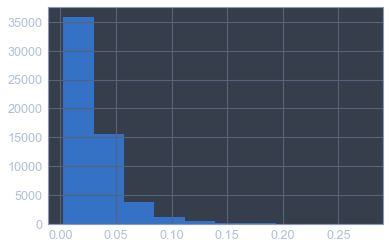

In [7]:
# test
test_matrix = xgboost.DMatrix(testV_X.values, feature_names=testV_X.columns)

pred_y = model.predict(test_matrix, ntree_limit=model.best_ntree_limit)
frame = pd.Series(pred_y, index=testV_df.index)
frame.name = 'predicted_score'
frame.hist()
print frame.value_counts().head()

pred_df = test_df[['instance_id']].join(frame)
ret_df = ret_test_df[['instance_id']].merge(pred_df)

print ret_df.describe()
print "test log loss:", log_loss(testV_y.values, pred_y)

0.066071    10
0.053295     8
0.061110     8
0.058699     7
0.055512     7
Name: predicted_score, dtype: int64
        instance_id  predicted_score
count  1.837100e+04     18371.000000
mean   4.607419e+18         0.050122
std    2.674410e+18         0.016898
min    1.772728e+14         0.009399
25%    2.287309e+18         0.037816
50%    4.627598e+18         0.048746
75%    6.928380e+18         0.061365
max    9.222350e+18         0.117504


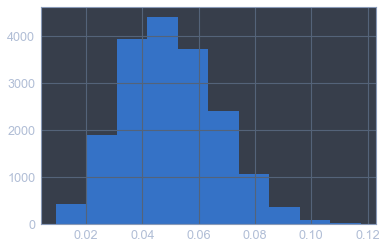

In [8]:
# predict
pred_y = model.predict(predict_matrix, ntree_limit=model.best_ntree_limit)
frame = pd.Series(pred_y, index=test_df.index)
frame.name = 'predicted_score'
frame.hist()
print frame.value_counts().head()

pred_df = test_df[['instance_id']].join(frame)
ret_df = ret_test_df[['instance_id']].merge(pred_df)

print ret_df.describe()

ret_df.to_csv('{0}_{1}/{1}_{2}'.format(cf.model_path, exec_time, cf.result_filename), sep=' ', index=False)